# Preprocess Data

In [2]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

%matplotlib inline

In [3]:
### Import get columns and rows
data = pd.read_csv("co2.csv",sep=',', comment='"',header=None,names=["date", "co2"])
data["date"] = pd.to_datetime(data["date"])

# make column of years passed, for seasonal variation
data["years_passed"] = [(d-data["date"][0]).days/365.25 for d in data["date"]] 


In [4]:
data.tail()

,date,co2,years_passed
3134,2019-08-31,409.32,61.423682
3135,2019-09-07,408.80,61.442847
3136,2019-09-14,408.61,61.462012
3137,2019-09-21,408.50,61.481177
3138,2019-09-28,408.28,61.500342


In [5]:
# generate dates to predict
# from last day til 2058, weekly on saturday
pred_dates = pd.date_range("2019-09-29", "2058-01-01", freq='W-SAT')
pred_years_passed = [(d-data["date"][0]).days/365.25 for d in pred_dates] 

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


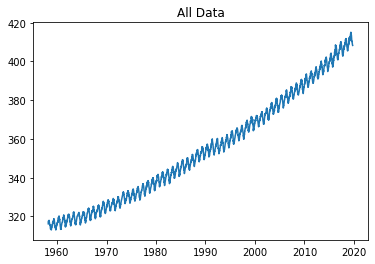

In [6]:
n = len(data)
n_future = len(pred_dates)

plt.plot(data["date"],data["co2"]);
plt.title("All Data");

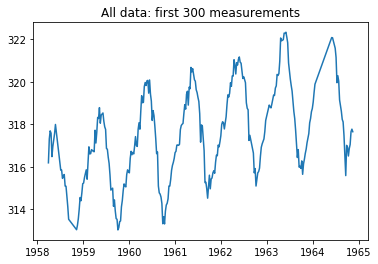

In [7]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot("date","co2",data=data[:300]);
ax.xaxis.set_major_locator(years);
ax.xaxis.set_major_formatter(years_fmt);
plt.title("All data: first 300 measurements");

# First Impressions

Generally linear trend with some type of compounding behavior. Either a quadratic or exponential

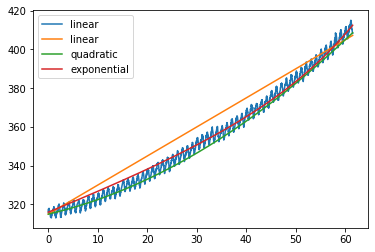

In [8]:
x = data["years_passed"]
plt.plot(x,data["co2"],label="linear");
plt.plot(x,[315+1.5*(i) for i in x],label="linear");
plt.plot(x,[315+0.6*(i) + 0.015*(i**2) for i in x], label="quadratic");
plt.plot(x,[315+1*(i) + 1.06**i for i in x], label="exponential");
plt.legend();

# Model Fitting

Pair plots show a unimodal shape and the samples are very uncorrelated. The samples should be usable.

# Trying with two sinusodals (one with double period)

In [10]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_code = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> n_future;
    real x[n];             // The co2 data (observed)
    real<lower=0> time[n];  // Observed time (in years passed)
    real<lower=0> time_future[n_future];  // Unobserved time (in years passed)
}

parameters {
    // _____POLY_____
    real<lower=0> C0;                            // constant
    real<lower=0> C1;                            // x multiplier
    real<lower=0> C2;                   // x^2 multiplier
    
    // _____PERIODIC_____
    real<lower=0> A1;                   // amplitude
    real phi_x;                        // dummy var for phi
    real phi_y;                        // "               "
    
    real<lower=0> A2;                   // amplitude w double period
    real<lower=0> A3;                   // amplitude w period 30 years
    
    // _____NOISE_____
    real<lower=0> sig;                 // periodic noise

}

transformed parameters {
    // atan converts to range [-pi,pi]
    real phi = atan2(phi_x, phi_y); // offset for period
}

model {
    // _____PRIORS_____
    C0 ~ normal(316, 50);
    C1 ~ cauchy(0, 1);
    C2 ~ cauchy(0,0.5);
    A1 ~ cauchy(3,1);
    A2 ~ cauchy(3,1);
    A3 ~ cauchy(3,1);
    sig ~ cauchy(0, 3);
    
    // _____MODEL_____
    for(t in 1:n) {
        x[t] ~ normal(
            C0 + C1*time[t] + C2*time[t]^2 +
            A1*cos(2*pi()*time[t] + phi) +
            A2*cos(4*pi()*time[t] + phi) +
            A3*cos(30*pi()*time[t] + phi)
            ,sig^2);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            C0 + C1*(time_future[t]) + C2*(time_future[t])^2 +
            A1*cos(2*pi()*time_future[t] + phi) +
            A2*cos(4*pi()*time_future[t] + phi) +
            A3*cos(30*pi()*time_future[t] + phi)
            ,sig^2); 
    }
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2ec4f02ad050d2fef740b604f430bb08 NOW.


In [11]:
stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data["co2"],
    'time': data["years_passed"],
    'time_future': pred_years_passed
} 

In [12]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['C0','C1','C2','A1','A2','A3','phi','sig']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_2ec4f02ad050d2fef740b604f430bb08.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C0  314.57  1.7e-3    0.1 314.37 314.52 314.57 314.62 314.77   3304    1.0
C1    0.77  1.5e-4 7.1e-3   0.75   0.76   0.77   0.77   0.78   2159   1.01
C2    0.01  5.9e-6 1.1e-4   0.01   0.01   0.01   0.01   0.01    352   1.02
A1    1.43    1.01   1.43 8.4e-5 1.2e-3   1.39   2.86    2.9      2   88.3
A2    0.41    0.29   0.41 6.5e-5 9.2e-4   0.31   0.81    0.9      2  10.82
A3    0.03  5.9e-3   0.03 1.0e-3   0.01   0.02   0.04    0.1     21   1.07
phi  -1.52    0.78   1.11  -2.75  -2.63  -1.44  -0.42   -0.4      2  24.67
sig   1.23    0.17   0.24   0.98   0.99   1.23   1.48   1.49      2   32.7

Samples were drawn using NUTS at Fri Dec 20 21:29:39 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and R

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


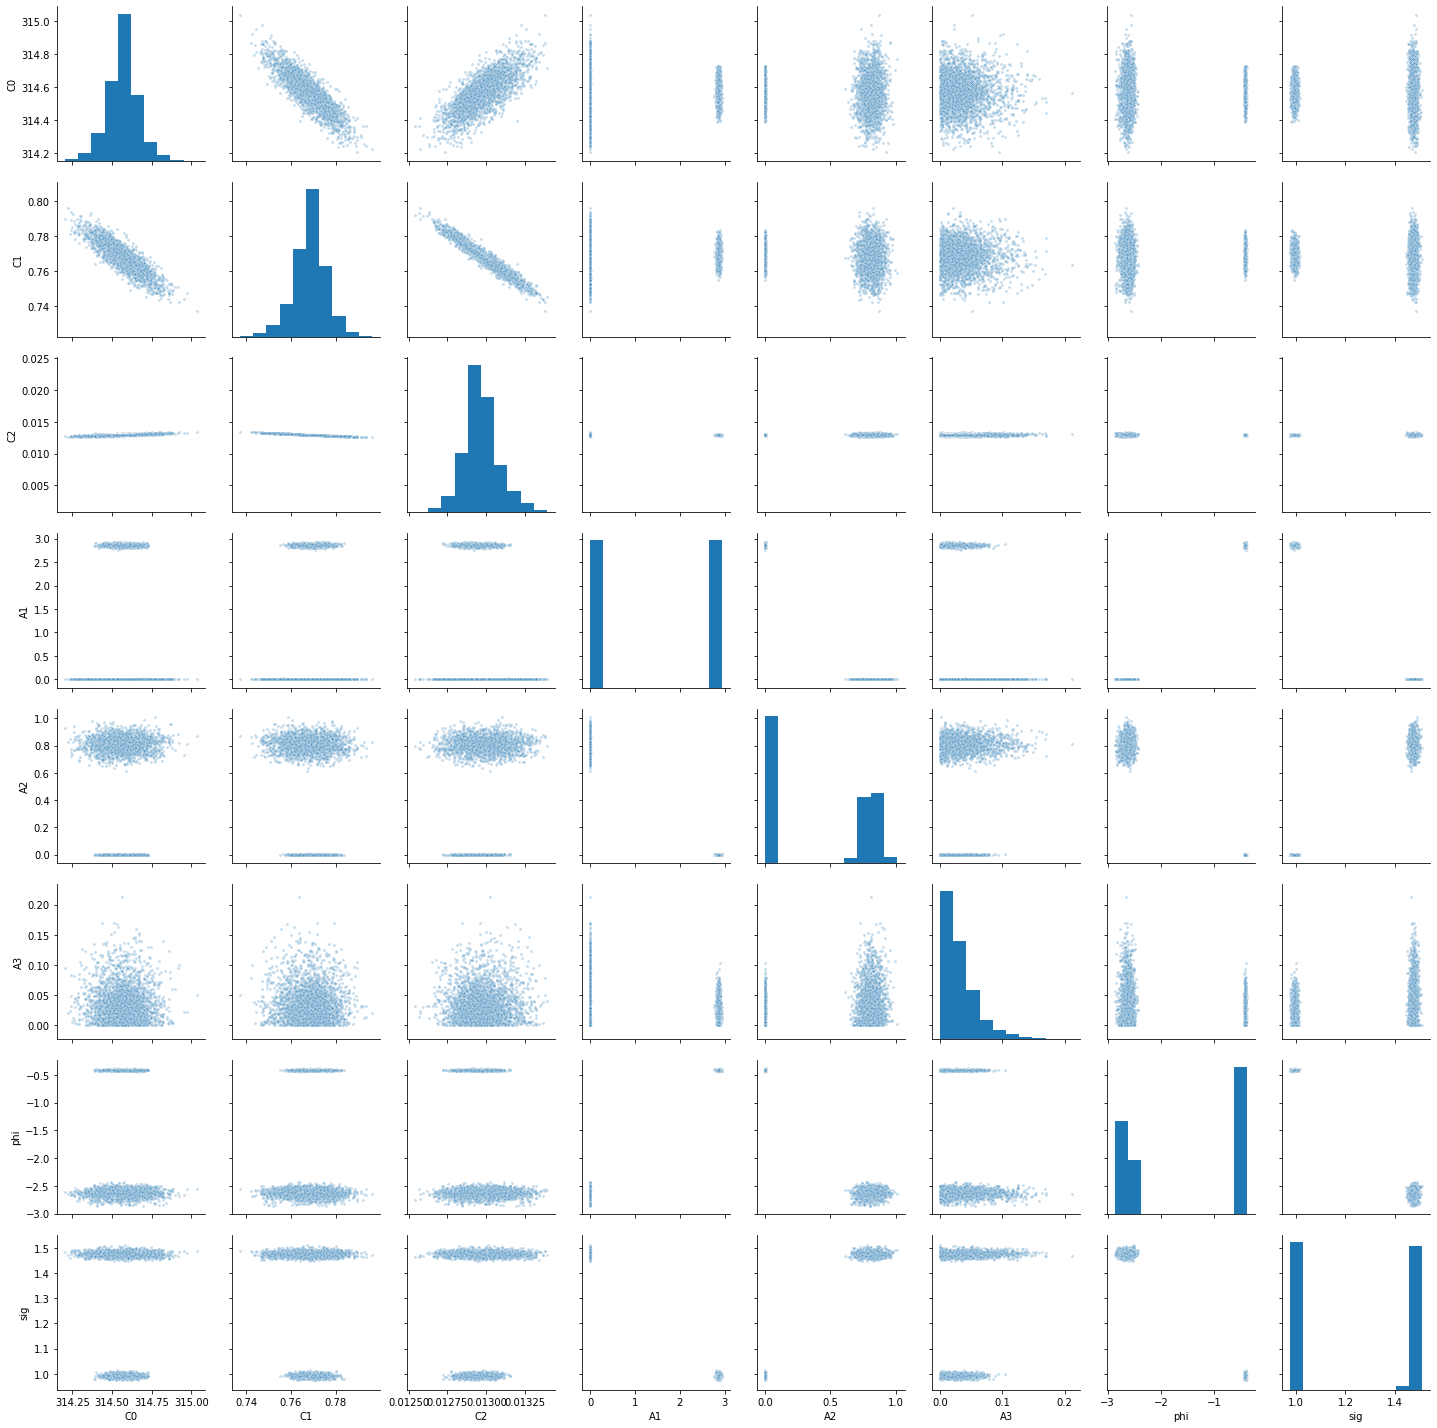

In [13]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

# Model Evaluation

In [53]:
# get predictions for past dates

past_model = []
for i in range(4000):
    if i%500 == 0:
        print(i)
    sample_year = []
    for t in data["years_passed"]:
        sample_year.append(stats.norm.rvs(samples["C0"][i] + samples["C1"][i]*t + samples["C2"][i]*t**2 + 
                                          samples["A1"][i]*math.cos(2*math.pi*t + samples["phi"][i]) + 
                                          samples["A2"][i]*math.cos(2*math.pi*t + samples["phi"][i]),
                                          samples["sig"][i]**2))
    past_model.append(sample_year)

0
500
1000
1500
2000
2500
3000
3500


In [54]:
# get 95% CI on past dates
past_percentiles = np.percentile(past_model, axis=0, q=[2.5, 97.5])

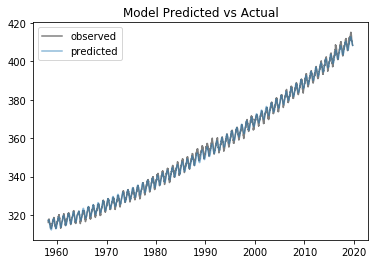

In [55]:
import math
plt.plot(data["date"],data["co2"], 'k-', label='observed',alpha=0.5) # observed data
plt.plot(data["date"],[np.mean(samples["C0"]) + np.mean(samples["C1"])*t + np.mean(samples["C2"])*t**2 + 
                       np.mean(samples["A1"])*math.cos(2*math.pi*t + np.mean(samples["phi"])) +
                       np.mean(samples["A2"])*math.cos(2*math.pi*t + np.mean(samples["phi"]))
                       for t in data["years_passed"]],label='predicted',alpha=0.5)
plt.legend()
plt.title('Model Predicted vs Actual');

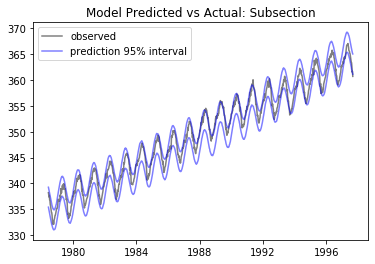

In [56]:
views = 1000
viewe = 2000
plt.plot(data["date"][views:viewe],data["co2"][views:viewe], 'k-', label='observed',alpha=0.5) # observed data
plt.plot(data["date"][views:viewe], past_percentiles[0,:][views:viewe],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(data["date"][views:viewe], past_percentiles[1,:][views:viewe],
    'b-', alpha=0.5)
plt.legend()
plt.title('Model Predicted vs Actual: Subsection');

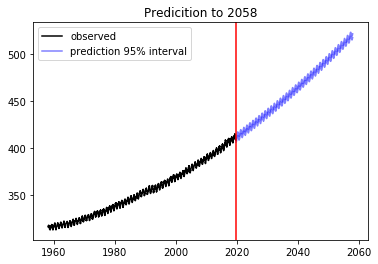

In [57]:
# get 95% percentile for prediction

prediction = samples['x_future'] 
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

plt.plot(data["date"],data["co2"], 'k-', label='observed') # observed data

# prediction interval
plt.plot(pred_dates, prediction_interval[0,:],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(pred_dates, prediction_interval[1,:],
    'b-', alpha=0.5)
plt.axvline(data["date"][len(data["date"])-1], color='red')
plt.legend()
plt.title("Predicition to 2058");

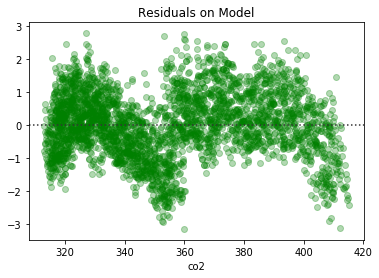

In [75]:
import seaborn as sns

predicted = [np.mean(samples["C0"]) + np.mean(samples["C1"])*t + np.mean(samples["C2"])*t**2 + 
                       np.mean(samples["A1"])*math.cos(2*math.pi*t + np.mean(samples["phi"])) +
                       np.mean(samples["A2"])*math.cos(2*math.pi*t + np.mean(samples["phi"]))
                       for t in data["years_passed"]]
sns.residplot(data["co2"],predicted, scatter_kws={'alpha':0.3}, color="g").set_title("Residuals on Model");

# Posterior Predictive Checks

In [58]:
def sampleTestStat(sample, func, *args):
    ts = []
    for s in sample:
        ts.append(func(s,*args))
    return(ts)

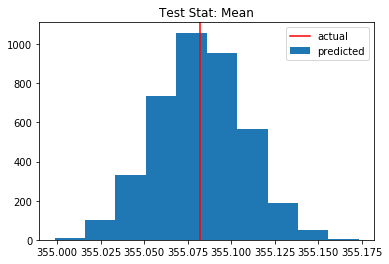

In [59]:
# Testing mean
real_m = np.mean(data["co2"])
sample_m = sampleTestStat(past_model, np.mean)

plt.hist(sample_m,label="predicted")
plt.axvline(real_m, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Mean");

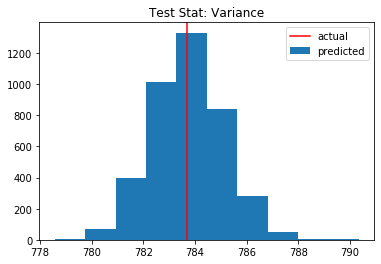

In [60]:
# Testing var
real_v = np.var(data["co2"])
sample_v = sampleTestStat(past_model, np.var)

plt.hist(sample_v,label="predicted")
plt.axvline(real_v, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Variance");

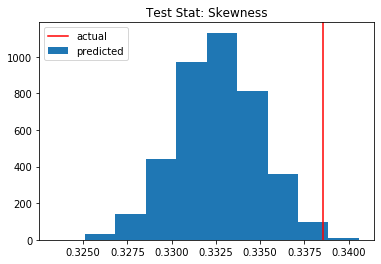

In [61]:
real_s = stats.skew(data["co2"])
sample_s = sampleTestStat(past_model, stats.skew)

plt.hist(sample_s,label="predicted")
plt.axvline(real_s, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Skewness");

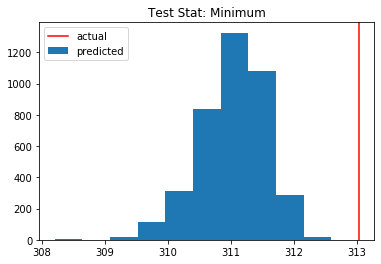

In [62]:
real_min = np.min(data["co2"])
sample_min = sampleTestStat(past_model, np.min)

plt.hist(sample_min,label="predicted")
plt.axvline(real_min, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Minimum");

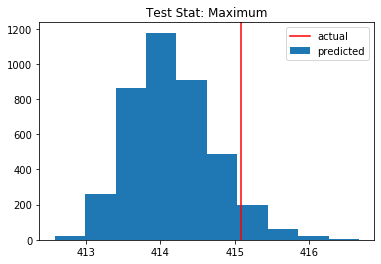

In [63]:
real_max = np.max(data["co2"])
sample_max = sampleTestStat(past_model, np.max)

plt.hist(sample_max,label="predicted")
plt.axvline(real_max, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Maximum");

Generally speaking, it looks like the actual data is a lot more right skewed than my model. Additionally, model minimum and maximum are too low.

It looks like there is some pattern in the data that I am not capturing in my model.

# Predictions based on Model

Carbon Dioxide levels projected until the start of 2058:

In [240]:
from tabulate import tabulate
mean_pred = np.mean(samples['x_future'],axis=0)

print(tabulate([[pred_dates[i].strftime('%Y-%m-%d'),mean_pred[i],prediction_interval[0][i],prediction_interval[1][i]] for i in range(n_future)],headers=['Date', 'Mean','2.5%','97.5%']))


Date           Mean     2.5%    97.5%
----------  -------  -------  -------
2019-10-05  408.185  406.24   410.107
2019-10-12  408.135  406.186  410.091
2019-10-19  408.125  406.165  410.079
2019-10-26  408.187  406.258  410.068
2019-11-02  408.279  406.382  410.288
2019-11-09  408.424  406.533  410.35
2019-11-16  408.572  406.605  410.562
2019-11-23  408.79   406.824  410.741
2019-11-30  409.028  407.168  411.019
2019-12-07  409.317  407.453  411.276
2019-12-14  409.599  407.643  411.646
2019-12-21  409.915  408      411.856
2019-12-28  410.272  408.373  412.275
2020-01-04  410.616  408.616  412.514
2020-01-11  411.009  409.056  412.98
2020-01-18  411.412  409.457  413.426
2020-01-25  411.795  409.857  413.819
2020-02-01  412.155  410.138  414.114
2020-02-08  412.567  410.522  414.469
2020-02-15  412.935  410.948  414.866
2020-02-22  413.287  411.323  415.255
2020-02-29  413.623  411.618  415.682
2020-03-07  413.901  411.934  415.954
2020-03-14  414.189  412.283  416.057
2020-03-21  41

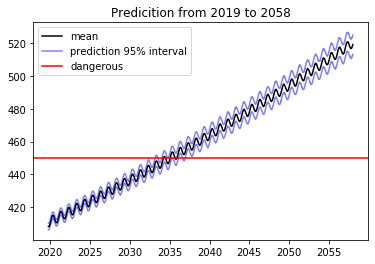

In [247]:
plt.plot(pred_dates, mean_pred, 'k-', label='mean') # observed data

# prediction interval
plt.plot(pred_dates, prediction_interval[0,:],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(pred_dates, prediction_interval[1,:],
    'b-', alpha=0.5)
plt.axhline(450, color='red',label="dangerous")
plt.legend()
plt.title("Predicition from 2019 to 2058");

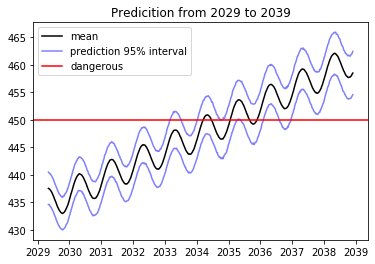

In [254]:
zs = 500
ze = 1000
plt.plot(pred_dates[zs:ze], mean_pred[zs:ze], 'k-', label='mean') # observed data

# prediction interval
plt.plot(pred_dates[zs:ze], prediction_interval[0,zs:ze],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(pred_dates[zs:ze], prediction_interval[1,zs:ze],
    'b-', alpha=0.5)
plt.axhline(450, color='red',label="dangerous")
plt.legend()
plt.title("Predicition from 2029 to 2039");

It is likely that we will reach dangerous levels of carbon dioxide around 2035